# Probabilistic Matrix Factorization 

***
## Abstract:
以ML-100K與million song dataset資料為範例，實作PMF與Constrained PMF模型。

Reference:  
[1]. Probabilistic Matrix Factorization.  
[2]. an overview of gradient descent optimization algorithms.  
[3]. https://zhuanlan.zhihu.com/p/34422451

<br>
***
## PMF Model
令評分資料為 $R_{N \times M}$，其中有N個Users與M個Items。本文透過矩陣分解的方式，建立模型 $\hat{R}=U^TV$，使得 $\hat{R} \approx R$。其中，$U_{D \times N}$ 為User矩陣，$V_{D \times M}$ 為item矩陣。簡單來說，模型透過矩陣分解的方式將評分矩陣分解為獨立(?)的U矩陣與V矩陣，並用D維的特徵(feature)來表示，已達到維度縮減、避免overfit的目的。

我們令評分資料R的機率分配為：
$$
p(R|U,V,\sigma^2) = \prod^N_i\prod^M_j{[N(R_{ij}| U^T_iV_j, \sigma^2)]^{I_{ij}}}
$$
其中$I_{ij}$為指標函數，若$R_{ij}$被觀察到則為1，否則為0。接著給定U與V的機率分配：
$$
p(U|\sigma_U^2) = \prod^N_i N(U_i | 0,\sigma_U^2I), \quad p(V|\sigma_V^2) = \prod^N_j N(V_j | 0,\sigma_V^2I)
$$

經過複雜的拆解後[3]，可以寫出log posterior:
$$
\ln p(U,V|R,\sigma^2,\sigma_U^2,\sigma_V^2)= -\frac{1}{2\sigma^2}\sum_i^N\sum^M_j I_{ij} ( R_{ij}-U_i^TV_j)^2 -
\frac{1}{2\sigma_U^2}\sum_i^N U_i^TU_i - 
\frac{1}{2\sigma_V^2}\sum_i^N V_j^TV_j \\ -
\frac{1}{2}[(\sum_i^N\sum^M_j I_{ij}) \ln \sigma^2 + ND\ln\sigma_U^2 + MD\ln\sigma_V^2] + C
$$
再經過一波整理，若設$\lambda_U = \frac{\sigma^2}{\sigma^2_U}$，$\lambda_V = \frac{\sigma^2}{\sigma^2_V}$並固定之，則極大化log posterior 同義於極小化 loss function E：
$$
E = \frac{1}{2}\sum_i^N\sum^M_j I_{ij} ( R_{ij}-U_i^TV_j)^2 + \frac{\lambda_U}{2}\sum_i^N \mid\mid U_i \mid \mid^2_{Fro} +
\frac{\lambda_V}{2}\sum_j^M \mid\mid V_j \mid \mid^2_{Fro}
$$


接著，為了找出極小化E的參數值，我們嘗試使用gradient descent的Adam法[2]。首先求出gradient
$$
\frac{\partial E}{U_i} = -\sum_j^MI_{ij}(R_{ij}-U_i^TV_j)V_j + \lambda_UU_i \\
\frac{\partial E}{V_j} = -\sum_i^NI_{ij}(R_{ij}-U_i^TV_j)U_i + \lambda_VV_j
$$
接著利用[3]的方法進行參數更新，直至迭代上限。此處我們使用Adam法，但是參數值是全部"龜一次"後，才會更新一次loss值。


***
## ML100K 實作：

#### Import modules

In [368]:
import numpy as np
import datetime
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

#### Load data:

In [361]:
with open("ml-100k/u.data",'r') as f:
    log = defaultdict(list)
    for line in f:
        user,item,rate,value = line.split("\t")
        log[int(user)].append([int(item),int(rate),int(value)])


#### Split data:
Here we take the last 5 movie rating of each user as test set.  
In other words, we use the past rating from each user to predict the latest five rating from them, as it is,in my opinion, a more realistic situation.

In [362]:
train = []
test = []
for key,value in log.items():
    value = sorted(value,key=lambda x:x[2])
    test_current =[[key]+value.pop() for i in range(5)]
    train_current = [[key]+item for item in value]
    train = train + train_current
    test = test + test_current

### Count how many user and item in log/train/test
Note that we have 943 users/1682 items in u.data.

In [363]:
temp = np.array(train)
user = Counter(temp[:,0])
item = Counter(temp[:,1])
print("###Train:\n   sample size:{}\n   User:{}, Item:{}, mean rating: {}".format(len(train),len(user),len(item),np.mean(temp[:,2])))

temp = np.array(test)
user = Counter(temp[:,0])
item = Counter(temp[:,1])
print("###Test:\n   sample size:{}\n   User:{}, Item:{}, mean rating: {}".format(len(test),len(user),len(item),np.mean(temp[:,2])))

del log,temp

###Train:
   sample size:95285
   User:943, Item:1671, mean rating: 3.5341029542950095
###Test:
   sample size:4715
   User:943, Item:1073, mean rating: 3.4441145281018026


## Main function of PMF with Adam:

In [365]:
def PMF_Adam(data,d=30,n_iter=10,n=943,m=1682,lambda_u=0.1,
             lambda_v=0.1,learning_rate=0.01,beta1=0.9,beta2=0.999,eps=0.999):
    
    n_train = len(data)
    loss_list = []
    mse_list = []
    
    #transform log data to matrix-like:
    r = np.zeros((n,m))
    for row,col,rate,_ in data:
        r[row-1,col-1]=rate
    r = np.array(r)
    
    #init u,v vector with normal(0,lambda):
    ut = np.random.normal(0,lambda_u,(n,d))
    v = np.random.normal(0,lambda_v,(d,m))
    
    # du_table : save past gradient mean and gradient square in list. take du_table for example:
    # du_table[i][t,mean,square] : i is the ith row of ut, t is t-th iter of parameter.
    #                              mean and square are d-dim np.array.    
    ##du_table = np.zeros((n,d,3))
    ##dv_table = np.zeros((d,m,3))    
    du_table = [[0,0,0] for i in range(n)]
    dv_table = [[0,0,0] for i in range(m)]    
    
    # parameter update order: [i,j], i=0 for row, i=1 for column. j is number of row or col.
    # Ex. [1,188] is column 188.
    # this order is suhffled everytime gradients are all updated.    
    order = [[0,i] for i in range(943)] + [[1,j] for j in range(1682)]
    
    #first loss:
    loss =0
    for row,col,rate,_ in data:
        loss = loss + (rate-np.dot(ut[row-1,:],v[:,col-1]))**2 
    mse = loss/n_train
    mse_list.append(mse)
    loss = loss/2 + lambda_u/2*np.sum(ut**2) + lambda_v/2*np.sum(v**2)
    loss_list.append(loss)
        
    #gradient decent start!!!
    for count in range(n_iter):
        np.random.seed(123)
        np.random.shuffle(order)
        for sel in order:
            # when col selected:
            if sel[0]:
                j = sel[1]
                #gradient:
                #dvj,mv,vv : d-dim array
                dvj = [ [-(r[i,j]-np.dot(ut[i,:],v[:,j]))*ut[i,:]] for i in np.nonzero(r[:,j])[0]]
                dvj = np.array(dvj) 
                dvj = np.sum(dvj,axis=0) + lambda_v*v[:,j]                
                #current moment:
                mv = beta1*dv_table[j][1] + (1-beta1)*dvj
                vv = beta2*dv_table[j][2] + (1-beta2)*(dvj**2)
                #moment update:
                dv_table[j] = adam_update(dv_table[j],dvj)
                #parameter update:
                v[:,j] = v[:,j] - learning_rate/(eps+np.sqrt(vv/(1-beta2**dv_table[j][0])))*(mv/(1-beta1**dv_table[j][0]))
            # when row selected:
            else:
                i = sel[1]
                #gradient:
                #dvj,mv,vv : d-dim array    
                #dui = np.zeros(30)
                #for j in np.nonzero(r[i,:])[0]:
                #    dui = dui -(r[i,j]-np.dot(ut[i,:],v[:,j]))*v[:,j]                 
                #####
                #dui = np.array(dui) + lambda_u*ut[i,:]                
                #dui = np.sum(dui,axis=0)                
                #dvj,mv,vv : d-dim array
                dui = [ [-(r[i,j]-np.dot(ut[i,:],v[:,j]))*v[:,j]] for j in np.nonzero(r[i,:])[0]]
                dui = np.array(dui)
                dui = np.sum(dui,axis=0) + lambda_u*ut[i,:]                
                
                #current moment:
                mu = beta1*du_table[i][1] + (1-beta1)*dui
                vu = beta2*du_table[i][2] + (1-beta2)*(dui**2)                
                #moment update:
                du_table[i] = adam_update(du_table[i],dui)
                #parameter update:
                ut[i,:] = ut[i,:] - learning_rate/(eps+np.sqrt(vu/(1-beta2**du_table[i][0])))*(mu/(1-beta1**du_table[i][0]))
        
        loss =0
        # update loss and mse
        for row,col,rate,_ in data:
            loss = loss + (rate-np.dot(ut[row-1,:],v[:,col-1]))**2 
        mse = loss/n_train
        mse_list.append(mse)
        loss = loss/2 + lambda_u/2*np.sum(ut**2) + lambda_v/2*np.sum(v**2)
        loss_list.append(loss)
        
    return loss_list,mse_list,ut,v        

# use to update first and second moment in Adam
def adam_update(li,d):
    if li[0]:
        t = li[0]+1
        li[1] = (li[1]*li[0]+d)/t
        li[2] = (li[2]*li[0]+d**2)/t
        li[0] = t
    else:
        li[0] = 1
        li[1] = d
        li[2] = d**2
    return li

## Lest's GO!
Train model with my pathetic algorithm!

In [392]:
print("Start Time: ",datetime.datetime.now())
loss,mse,ut,v = PMF_Adam(train,n_iter=500)
print("End Time: ",datetime.datetime.now())

Start Time:  2018-08-30 15:43:05.668313
End Time:  2018-08-30 15:57:06.314910


#### Loss function and MSE in iteration

Text(0.5,1,'Mse')

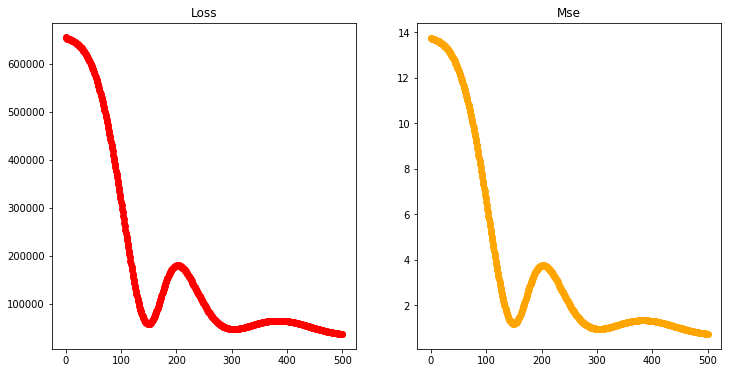

In [394]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x=list(range(501)),c="red",y=loss)
plt.title("Loss")
plt.subplot(122)
plt.scatter(x=list(range(501)),c="orange",y=mse)
plt.title("Mse")

#### RMSE in train data:

In [403]:
np.sqrt(mse[-1])

0.86675783775617099

#### MSE in test data:

In [416]:
mse = 0
for row,col,rate,_ in test:
    mse = mse + (rate-np.dot(ut[row-1,:],v[:,col-1]))**2
mse = np.mean(mse/len(test))
rmse = np.sqrt(mse)
print(rmse)

1.15518387725


#### How many items not in the training set:

In [426]:
train_item = [item[1] for item in train]
test_item = [item[1] for item in test]
missing_item = set(test_item) - set(train_item)
print(missing_item)

{1671, 1130, 1674, 1613, 1645, 1618, 1650, 1236, 1525, 1624, 1625}


#### how many rates among this items?

In [427]:
count = 0
for item in test_item:
    if item in missing_item:
        count = count +1
print(count)

11
